In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Keras의 Random Seed 설정은 np.random.seed( )를 통해 해줄 수 있다.
# 재현성 잡힌 Image Load & Augmentation 결과를 얻고 싶다면 np.random.seed( )를 설정

# 즉 datagen을 이용해서 이미지를 증식하는 방법을 사용하기 때문에
# 실행할때 마다 결과가 조금씩 다를 수 있다. 해당 결과를 실행마다 같게하기위해서 시드 설정
np.random.seed(15)

In [24]:
from keras.preprocessing.image import ImageDataGenerator
# -------- 테스트용 -------------

# Gen으로 데이터를 생성하려고 하는게아닌 이미지 폴더를 image, label로 분리하고 검증용 데이터를 분리하기 위해서 사용했고
# 또한 사용하면 이미지 사이즈나 클래스 모드를 사용할 수 있기 때문에 사용했습니다.

#  이미지 4장을 한 번에 읽어들이기 위해 batch_size = 4으로 설정
batch_size = 4

# 생성시에 파라미터를 설정하면 어떻게 augmentation를 진행할지 지정할 수 있다.
datagen = ImageDataGenerator(
    featurewise_center = True)

# 경로, 셔플, 이미지사이즈, 한번에 읽어올 이미지 수, 클래스 모드
generator = datagen.flow_from_directory(
    'C:\\vsCode\\PillProject\\imageT\\color\\test', 
    shuffle = True, 
    target_size=(256,256), 
    batch_size=batch_size, 
    class_mode = 'categorical')

Found 64 images belonging to 5 classes.


In [25]:
# 생성된 총 이미지 개수와 반복문의 실행 수를 계산
n_img = generator.n
steps = n_img // batch_size

# 이미지를 저장할 리스트와 라벨을 저장할 리스트 사용
imgs, labels = [], []
# 반복문의 실행 수 만큼 반복
for i in range(steps):
    # gen으로 데이터를 가져와서 각각의 리스트에 추가
    a, b = generator.next()
    imgs.extend(a)
    labels.extend(b)

# 이미지와 라벨이 실수형으로 되어있기 때문에 정수형으로 변환
test_images = np.asarray(imgs, dtype=np.uint8)
labels = np.asarray(labels, dtype=np.uint8)

# 라벨이 [0,0,1,0,0]이런식으로 되어있기 때문에 [2] 이런식으로 모두 변형
test_labels = []
for i in labels:
    rank = 0
    for ii in i:
        if(ii == 1):
            break
        rank += 1
    list1 = []
    list1.append(rank)
    test_labels.extend(list1)
# 라벨또한 다시 정수형으로 변경
labels = np.asarray(test_labels, dtype=np.uint8)
# 1차원 배열형식으로 되어있어서 2차원 배열로 변경
test_labels = labels[:, np.newaxis]

In [5]:
from keras.preprocessing.image import ImageDataGenerator
# -------- 훈련용 -------------
batch_size = 4

datagen = ImageDataGenerator(
    validation_split = 0.3, 
    featurewise_center = True)
generator = datagen.flow_from_directory(
    'C:\\vsCode\\PillProject\\imageT\\color\\train', 
    shuffle = True, 
    target_size=(256,256), 
    batch_size=batch_size, 
    class_mode = 'categorical')

Found 750 images belonging to 5 classes.


In [6]:
n_img = generator.n
steps = n_img // batch_size

imgs, labels = [], []
for i in range(steps):
    a, b = generator.next()
    imgs.extend(a)
    labels.extend(b)

train_images = np.asarray(imgs, dtype=np.uint8)
labels = np.asarray(labels, dtype=np.uint8)

train_labels = []
for i in labels:
    rank = 0
    for ii in i:
        if(ii == 1):
            break
        rank += 1
    list1 = []
    list1.append(rank)
    train_labels.extend(list1)
labels = np.asarray(train_labels, dtype=np.uint8)
train_labels = labels[:, np.newaxis]

In [26]:
# 테스트용 이미지와 훈련용 이미지 개수 확인
print(len(test_images))
print(len(test_labels))
print(len(train_images))
print(len(train_labels))

64
64
748
748


IndexError: arrays used as indices must be of integer (or boolean) type

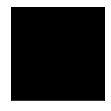

In [29]:
# 이미지들이 라벨에 어떠한 이미지인지 분류가 되어있긴 하나 숫자로만 되어있음
# 클래스의 이름
class_names = ['blue', 'green', 'orange', 'red', 'white']
class_names = np.array(class_names)
# 예시로 보여줄 사진 크기
plt.figure(figsize=(10,10))

# 25장의 이미지만 예시로 보여줄 것
for i in range(25):
    # 5행 5열로 이미지를 보여줌
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # 이미지 보여주기
    plt.imshow(train_images[i], cmap = plt.cm.binary)
    # 이미지마다 이름 보여주기 
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [28]:
# 배치 사이즈의 수만큼 이미지를 학습하고 가중치를 갱신하게된다.
# 배치 사이즈를 증가시키면 필요한 메모리가 증가하나 모델을 훈련하는데 시간이 적게 든다.
# 배치 사이즈를 감소시키면 필요한 메모리가 감소하나 모델을 훈련하는데 시간이 많이 든다.
batch_size = 64
# 분류될 클래스 개수
num_classes = 5
# 몇번 학습을 반복할 것인지 결정
# 에포크가 많다면 과적합 문제 발생가능, 적다면 분류를 제대로 못할 수 있다.
epochs = 50

#훈련용 이미지 실수로 변경 (1과 0 사이 값)
train_images = train_images.astype('float32')
train_images = train_images/255

# 테스트 이미지 실수로 변경 (1과 0 사이 값)
test_images = test_images.astype('float32')
test_images = test_images/255

# 라벨들 이진핫코딩 ([0],[0],[0],[0],[1]) 형식
train_labels = utils.to_categorical(train_labels, num_classes)
test_labels = utils.to_categorical(test_labels, num_classes)


In [10]:
# 모델 구성
model = keras.Sequential([
    Conv2D(32, kernel_size = (3,3), padding = 'same', input_shape = train_images.shape[1:],
          activation=tf.nn.relu),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(64, kernel_size = (3,3), padding = 'same', activation=tf.nn.relu),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(64, activation=tf.nn.relu),
    Dropout(0.25),
    Dense(num_classes, activation=tf.nn.softmax)
])
# 모델의 신경망 구조 확인
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 64)        0

In [11]:
# 모델을 학습시키기 전 환경 설정 (정규화기, 손실함수, 평가지표)

# 정규화기 - 훈련과정을 설정합니다. 즉, 최적화 알고리즘을 설정을 의미합니다.
# adam, sgd, rmsprop, adagrad 등이 있습니다.

# 손실함수 - 모델이 최적화에 사용되는 목적 함수입니다.
# mse, categorical_crossentropy, binary_crossentropy 등이 있습니다.

# 평가지표 - 훈련을 모니터링 하기 위해 사용됩니다.
# 분류에서는 accuracy, 회귀에서는 mse, rmse, r2, mae, mspe, mape, msle 등이 있습니다.
# 사용자가 메트릭을 정의해서 사용할 수도 있습니다.
model.compile(
    loss='categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [12]:
# 과적합을 방지하기 위해서 설정
early_stopping=EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    validation_data=(test_images, test_labels),
    shuffle=True,
    # 콜백을 적용하면 과적합을 방지하는지는 잘 모르겠음.
    # 다만, 적용시키면 훈련을 12~20번 사이로 하고 그냥 에포크 상관없이 훈련을 중지함.
     callbacks=[early_stopping]
)

Epoch 1/50
24/24 [==============================] - 7s 130ms/step - loss: 6.6865 - accuracy: 0.5281 - val_loss: 1.1543 - val_accuracy: 0.5156
Epoch 2/50
24/24 [==============================] - 2s 100ms/step - loss: 0.2851 - accuracy: 0.9144 - val_loss: 0.5225 - val_accuracy: 0.9688
Epoch 3/50
24/24 [==============================] - 2s 100ms/step - loss: 0.1188 - accuracy: 0.9693 - val_loss: 0.4521 - val_accuracy: 0.9219
Epoch 4/50
24/24 [==============================] - 2s 101ms/step - loss: 0.1108 - accuracy: 0.9693 - val_loss: 0.7999 - val_accuracy: 0.6094
Epoch 5/50
24/24 [==============================] - 2s 102ms/step - loss: 0.0915 - accuracy: 0.9719 - val_loss: 0.2665 - val_accuracy: 1.0000
Epoch 6/50
24/24 [==============================] - 2s 101ms/step - loss: 0.0533 - accuracy: 0.9840 - val_loss: 0.2496 - val_accuracy: 0.9688
Epoch 7/50
24/24 [==============================] - 2s 99ms/step - loss: 0.0381 - accuracy: 0.9880 - val_loss: 0.1020 - val_accuracy: 1.0000
Epoch 8

In [14]:
# 훈련이 완료되고 나서 평가
loss, acc = model.evaluate(test_images, test_labels)
print('\nLoss : {}, Acc : {}'.format(loss,acc))
#  softmax cross-entropy loss를 사용할 경우 loss 값이 의미하는 바는 단순히 
#     "i번째 index가 정답일 때에, i번째 index에 해당하는 softmax 값의 log 평균"이다.그러니까 
#     loss 값이 0.05인 경우, 정답에 대해 평균적으로 e^(-0.05)=0.95 정도의 softmax 확률 값을 가졌다는 의미

2/2 [==============================] - 0s 44ms/step - loss: 0.1028 - accuracy: 0.9531

Loss : 0.10279396176338196, Acc : 0.953125


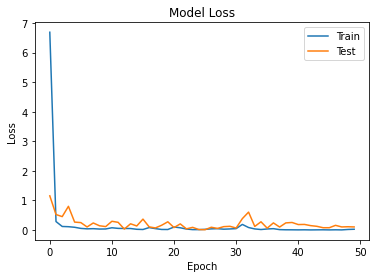

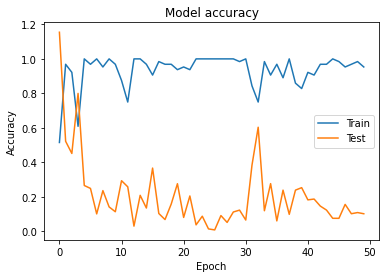

In [15]:
# 평가 함수 만들기
def plot_show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)
    
def plot_show_acc(history):
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['val_loss'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc=0)
    
plot_show_loss(history)
plt.show()

plot_show_acc(history)
plt.show()

In [17]:
# 예측
predictions = model.predict(test_images)

2/2 [==============================] - 0s 28ms/step


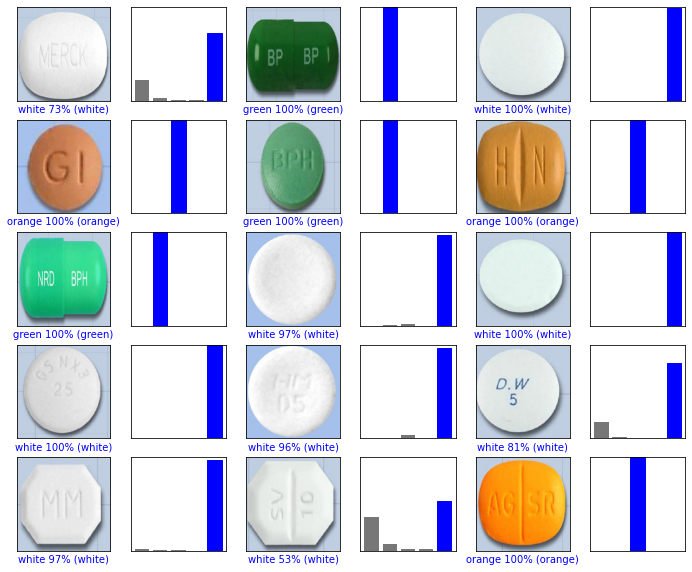

In [18]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == np.argmax(true_label):
        # 테스트 이미지와 모델이 분류한 이미지가 같으면 그래프를 파란색으로
        color = 'blue'
    else:
        # 테스트 이미지와 모델이 분류한 이미지 분류와 다르면 그래프를 빨간색으로
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[np.argmax(true_label)]),
                                        color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[np.argmax(true_label)].set_color('blue')

    
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)
plt.show()

In [23]:
# 6. 모델 저장하기
from keras.models import load_model
model.save('image_color.h5')